In [4]:
import cv2
import yaml
import tensorflow as tf

import numpy as np
import yaml

In [5]:
tflite_path = ["yolov5.tflite",
            "yolov5model_dynamic_range_quant.tflite",
            "yolov5model_float16_quant.tflite",
            "yolox_nano_dynamic_range_quantize.tflite",
            "yolox_nano_int8_quantize.tflite"]

In [6]:
for model_name in tflite_path:
    interpreter = tf.lite.Interpreter(model_path=model_name)
    interpreter.allocate_tensors()
    # Get the model inputs
    print("="*80)
    print(f"{model_name} 's inpute detail")
    input_details = interpreter.get_input_details()
    print(input_details)
    # output_details = interpreter.get_output_details()

yolov5.tflite 's inpute detail
[{'name': 'input_1', 'index': 0, 'shape': array([  1, 320, 320,   3], dtype=int32), 'shape_signature': array([  1, 320, 320,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
yolov5model_dynamic_range_quant.tflite 's inpute detail
[{'name': 'serving_default_images:0', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
yolov5model_float16_quant.tflite 's inpute detail
[{'name': 'serving_default_images:0', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [150]:

def preprocess(path):
    """
    Preprocesses the input image before performing inference.

    Returns:
        image_data: Preprocessed image data ready for inference.
    """
    input_width = 640
    input_height = 640
    # Read the input image using OpenCV
    img = cv2.imread(path)

    # Get the height and width of the input image
    img_height, img_width = img.shape[:2]
    print(img_height, img_width)
    # Convert the image color space from BGR to RGB
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match the input shape
    img = cv2.resize(image, (input_width, input_height))

    # Normalize the image data by dividing it by 255.0
    image_data = np.array(img) / 255.0

    # Transpose the image to have the channel dimension as the first dimension
    # image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

    # Expand the dimensions of the image data to match the expected input shape
    image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

    # Return the preprocessed image data
    return image,image_data


In [151]:
img,img_data = preprocess("test_imgs/09.png")

272 480


In [152]:
interpreter.set_tensor(input_details[0]['index'], img_data )
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
# class_data = interpreter.get_tensor(output_details[1]['index'])
# score_data = interpreter.get_tensor(output_details[2]['index'])
# N_data = interpreter.get_tensor(output_details[3]['index'])

In [153]:
output.shape

(1, 25200, 85)

In [154]:
output[0][14]

array([     115.52,       2.945,      25.705,       9.071,  5.6259e-06,     0.28802,   0.0025542,    0.014354,   0.0012606,  0.00066447,  0.00064692,   0.0004833,    0.001277,    0.003421,   0.0074996,   0.0005934,   0.0011156,  0.00095341,   0.0044184,    0.035837,   0.0018506,   0.0033723,   0.0032744,   0.0057148,
         0.0084503,    0.003704,   0.0011291,    0.001911,   0.0016179,     0.01488,   0.0053148,     0.01424,    0.031122,   0.0035124,   0.0033977,   0.0033849,   0.0026768,    0.016775,    0.015687,   0.0037825,   0.0066811,   0.0021984,   0.0058399,     0.00139,    0.030458,   0.0041106,    0.018729,   0.0065119,
          0.010899,   0.0028031,   0.0033508,   0.0023346,   0.0025184,  0.00093949,   0.0033504,   0.0024176,   0.0071832,   0.0024902,   0.0012558,   0.0023638,   0.0023476,    0.032035,  0.00087251,    0.003476,  0.00081213,   0.0015985,  0.00057016,   0.0024823,   0.0019312,   0.0025532,     0.01664,   0.0013353,
          0.020865,  0.00060488,  0.0007459

In [135]:
output[0][8][:4]*416

array([     414.38,      414.38,      414.38,      414.38], dtype=float32)

In [137]:
from ultralytics.utils.ops import xyxy2xywh
x, y, w, h = xyxy2xywh(output[0][8][:4]*416)

In [138]:
x

414.375

In [79]:
sum(score_data[0])

0.98828125

In [80]:
N_data 

array([10.], dtype=float32)

In [81]:
rows = int(N_data[0])
boxes = box_data[0]
scores = score_data[0]
class_ids = class_data[0]

x_factor = 540 / 300
y_factor = 960 / 300


In [82]:

def draw_detections( img, box, score, class_id):
    """
    Draws bounding boxes and labels on the input image based on the detected objects.

    Args:
        img: The input image to draw detections on.
        box: Detected bounding box.
        score: Corresponding detection score.
        class_id: Class ID for the detected object.

    Returns:
        None
    """
    x_factor = 540
    y_factor = 960
    # x1, y1, w, h = box
    x1, y1, x2, y2 = box
    x1,x2 = x1*x_factor,x2*x_factor
    y1,y2 = y1*y_factor,y2*y_factor


    # Retrieve the color for the class ID
    color_palette = [(0, 255, 0),( 255,0, 0)]
    # print(class_id)
    color = color_palette[int(class_id)]
    # print(color)
    # Draw the bounding box on the image
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

    # Create the label text with class name and score
    label = f'{class_id}: {score:.2f}'

    # Calculate the dimensions of the label text
    (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

    # Calculate the position of the label text
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
    # print((label_x, label_y - label_height))
    # Draw a filled rectangle as the background for the label text
    cv2.rectangle(img, (int(label_x), int(label_y - label_height)), (int(label_x + label_width), int(label_y + label_height)), color,
                cv2.FILLED)

    # Draw the label text on the image
    cv2.putText(img, label, (int(label_x), int(label_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)


In [83]:
from keras_cv import visualization


In [84]:
for i in range(len(boxes)):
    
    # Get the box, score, and class ID corresponding to the index
    box = boxes[i]
    score = scores[i]
    class_id = class_ids[i]
    # self.predresult.append((class_id,box,score))
    # Draw the detection on the input image
    if class_id in [0,2]:
        # print(class_id)
        if score > 0.11:
            draw_detections(img, box, score, class_id)
            print(class_id)
# Return the modified input image
# return input_image


0.0
0.0


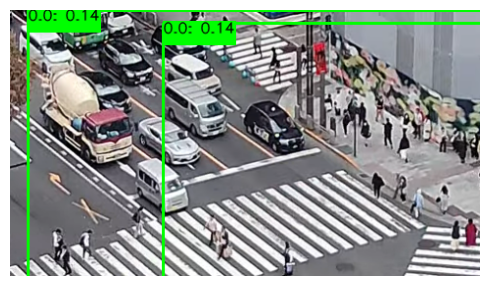

In [85]:
visualization.plot_image_gallery(
    np.array([img]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)